# [WB] PD5 - Kacper Siemaszko & Mateusz Polakowski

Praca domowa polegała na stworzeniu metamodelu na podstawie posiadanych już zbiorów danych oraz opartych na nich modeli. Warto zwrócić uwagę na reprodukowalność kodu - w przypadku powstania kolejnych zbiorów / modeli wystarczy notatnik ponownie uruchomić aby uzyskać nowe wyniki.

---
### Załadowanie potrzebnych pakietów

In [10]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import category_encoders as ce

import pandas as pd
import numpy as np
import json
import os

import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (25,17)

### Kod zbierający dane dotyczące modeli i zbiorów danych

In [13]:
path = "./../models"
df = pd.DataFrame()

for dataset in os.listdir("./../models"):
    if os.path.isdir(os.path.join(path, dataset)) and not dataset.startswith("."):
        for task in os.listdir(os.path.join(path, dataset)):
            if os.path.isdir(os.path.join(path, dataset, task)) and not task.startswith("."):
                with open(os.path.join(path, dataset, "dataset.json"), 'r') as f:
                    dataset_info = json.load(f)
                    dataset_info = dict([(key, dataset_info[0][key]) for key in 
                                         ['number_of_features',
                                          'number_of_instances',
                                          'number_of_missing_values',
                                          'number_of_instances_with_missing_values']])
                    if not task.startswith("classification"):
                        continue
                    for model in os.listdir(os.path.join(path, dataset, task)):
                        try:
                            if os.path.isdir(os.path.join(path, dataset, task, model)):
                                with open(os.path.join(path, dataset, task, model, "audit.json")) as fa:
                                    audit_info = json.load(fa)
                                    audit_info = dict([(metrics, audit_info[0]['performance'][metrics]) 
                                                       for metrics in ['acc', 
                                                                       'auc',
                                                                       'specificity',
                                                                       'recall', 
                                                                       'precision',
                                                                       'f1']])
                                with open(os.path.join(path, dataset, task, model, "model.json")) as fm:
                                    model_info = json.load(fm)
                                    categorical_counter = 0
                                    numerical_counter = 0
                                    for key, value in model_info[0]['preprocessing'].items():
                                        if value['type']=='categorical':
                                            categorical_counter+=1
                                        elif value['type']=='numerical':
                                            numerical_counter+=1
                                    model_info = dict([(key, model_info[0][key]) 
                                                      for key in ['id',
                                                                  'library',
                                                                  'model_name' #,'added_by'
                                                                 ]])
                                    model_info['categorical_counter']=categorical_counter      
                                    model_info['numerical_counter']=numerical_counter
                                model = dataset_info
                                model.update(audit_info)
                                model.update(model_info)
                                model = pd.DataFrame.from_dict(model, orient='index').T
                                df = df.append(model, ignore_index=True)
                        except :
                            continue
                            
df.loc[:,'missing_values_fraction'] = df.number_of_instances_with_missing_values/df.number_of_instances

In [14]:
# Podgląd danych
df.sample(5)

,number_of_features,number_of_instances,number_of_missing_values,number_of_instances_with_missing_values,acc,auc,specificity,recall,precision,f1,id,library,model_name,categorical_counter,numerical_counter,missing_values_fraction
41,5,1372,0,0,0.9927,0.9999,0.9949,0.9908,0.9962,0.9935,7e887a1f134ecfa0e2632ffb1169044d,mlr,classif.ranger,1,4,0
175,12,4898,0,0,0.6754,None,None,None,None,None,56a96a6662aa8c7bee3d8b6d39c7e9dd,mlr,classif.ranger,1,11,0
212,35,366,8,8,0.9721,None,None,None,None,None,3c8d9655e5429229bf7c0a41343adadd,mlr,classif.gbm,34,1,0.0218579
253,21,1000,0,0,0.753,0.7903,0.414,0.8968,0.7826,0.8353,db1814c4178aa2d2eda18118db291c72,mlr,classif.randomForest,14,7,0
90,18,101,0,0,0.8904,0.7424,0.0833,0.9555,0.9259,0.9402,147da89c2ea06175928b517c966f7594,mlr,classif.ada,17,1,0


Na potrzeby zadania należy z powyższego zbioru wyodrębnić kilka kolumn, które chcemy przewidywać. Ponadto, oprócz wyodrębnienia, trzeba je wykluczyć z tabeli X. Oprócz nich znajdują się również takie, które dodawały niepotrzebny szum wsród danych i utrudniały pracę modelu.

In [122]:
X, y_acc, y_auc, y_precision, y_recall, y_specificity, y_f1 = df.drop(['acc',
                                                                       'auc',
                                                                       'precision',
                                                                       'recall',
                                                                       'specificity',
                                                                       'f1',
                                                                       'id',
                                                                       'number_of_instances_with_missing_values'],
                                                                      axis=1), df.acc, df.auc, df.precision, df.recall, df.specificity, df.f1

---
# Tworzenie metamodelu
Nasz metamodel oparliśmy najpierw na odpowiednim zakodowaniu zmiennych kategorycznych, a następnie predykcji modelu *GradientBoostingRegressor* pakietu *sklearn.ensemble*. Całą ewaluację zamknęliśmy w ciało jednej funkcji, która na podstawie podanych wartości wylicza predykcję oraz błąd średniokwadratowy.
<br/>
Poniżej można znaleźć wyniki metamodelu, które można uznać za satysfakcjonujące. Ponadto zawarliśmy przykładowy wykres *feature_importances* w przypadku wyliczania *accuracy* modelu.
## Definicja funkcji do ewaluacji metamodelu

In [189]:
def evaluate_model(X, y, model, draw_importances=False):
    """
        Funkcja najpierw wyznacza predykcję na podstawie posiadanych danych i modelu.
        Następnie wylicza i zwraca mean_squared_error.
        Dodatkowo, niedomyślnie, funkcja rysuje wykres hierarchii cech modelu.
    """
    X_train, X_test, y_train, y_test = train_test_split(X[np.logical_not(y.isna())], 
                                                            y_acc[np.logical_not(y.isna())], 
                                                            test_size=0.2,
                                                            random_state=42)
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
     
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    if draw_importances == True:
        importances = pd.Series(dict(zip(X.columns, model.steps[2][1].feature_importances_)))
        importances.sort_values().plot(kind='barh', color='royalblue')
        plt.title("Hierarchia cech modelu\n", fontsize=43)
        plt.yticks(fontsize=30)
        plt.show()
        return
    
    return np.round(mean_squared_error(y_test, y_pred), 4)

## Definiowanie metamodelu i jego ewaluacja

In [190]:
# Pipeline dla danych wejściowych
steps = [('binary_encoder', ce.BinaryEncoder(cols=['model_name'])),
         ('ordinal_encoder', ce.OrdinalEncoder(cols=['library'])),
         ('rfr', GradientBoostingRegressor(n_estimators=1000, max_depth=3, random_state=42))]
model_pipeline = Pipeline(steps)

In [191]:
pd.DataFrame({
    "Accuracy": [evaluate_model(X, y_acc, model_pipeline)],
    "AUC": [evaluate_model(X, y_auc, model_pipeline)],
    "Precision": [evaluate_model(X, y_precision, model_pipeline)],
    "Recall": [evaluate_model(X, y_recall, model_pipeline)],
    "Specificity": [evaluate_model(X, y_specificity, model_pipeline)],
    "F1": [evaluate_model(X, y_f1, model_pipeline)]
})

,Accuracy,AUC,Precision,Recall,Specificity,F1
0,0.0063,0.0016,0.0023,0.0023,0.0023,0.0023


### Przykład hierarchii cech

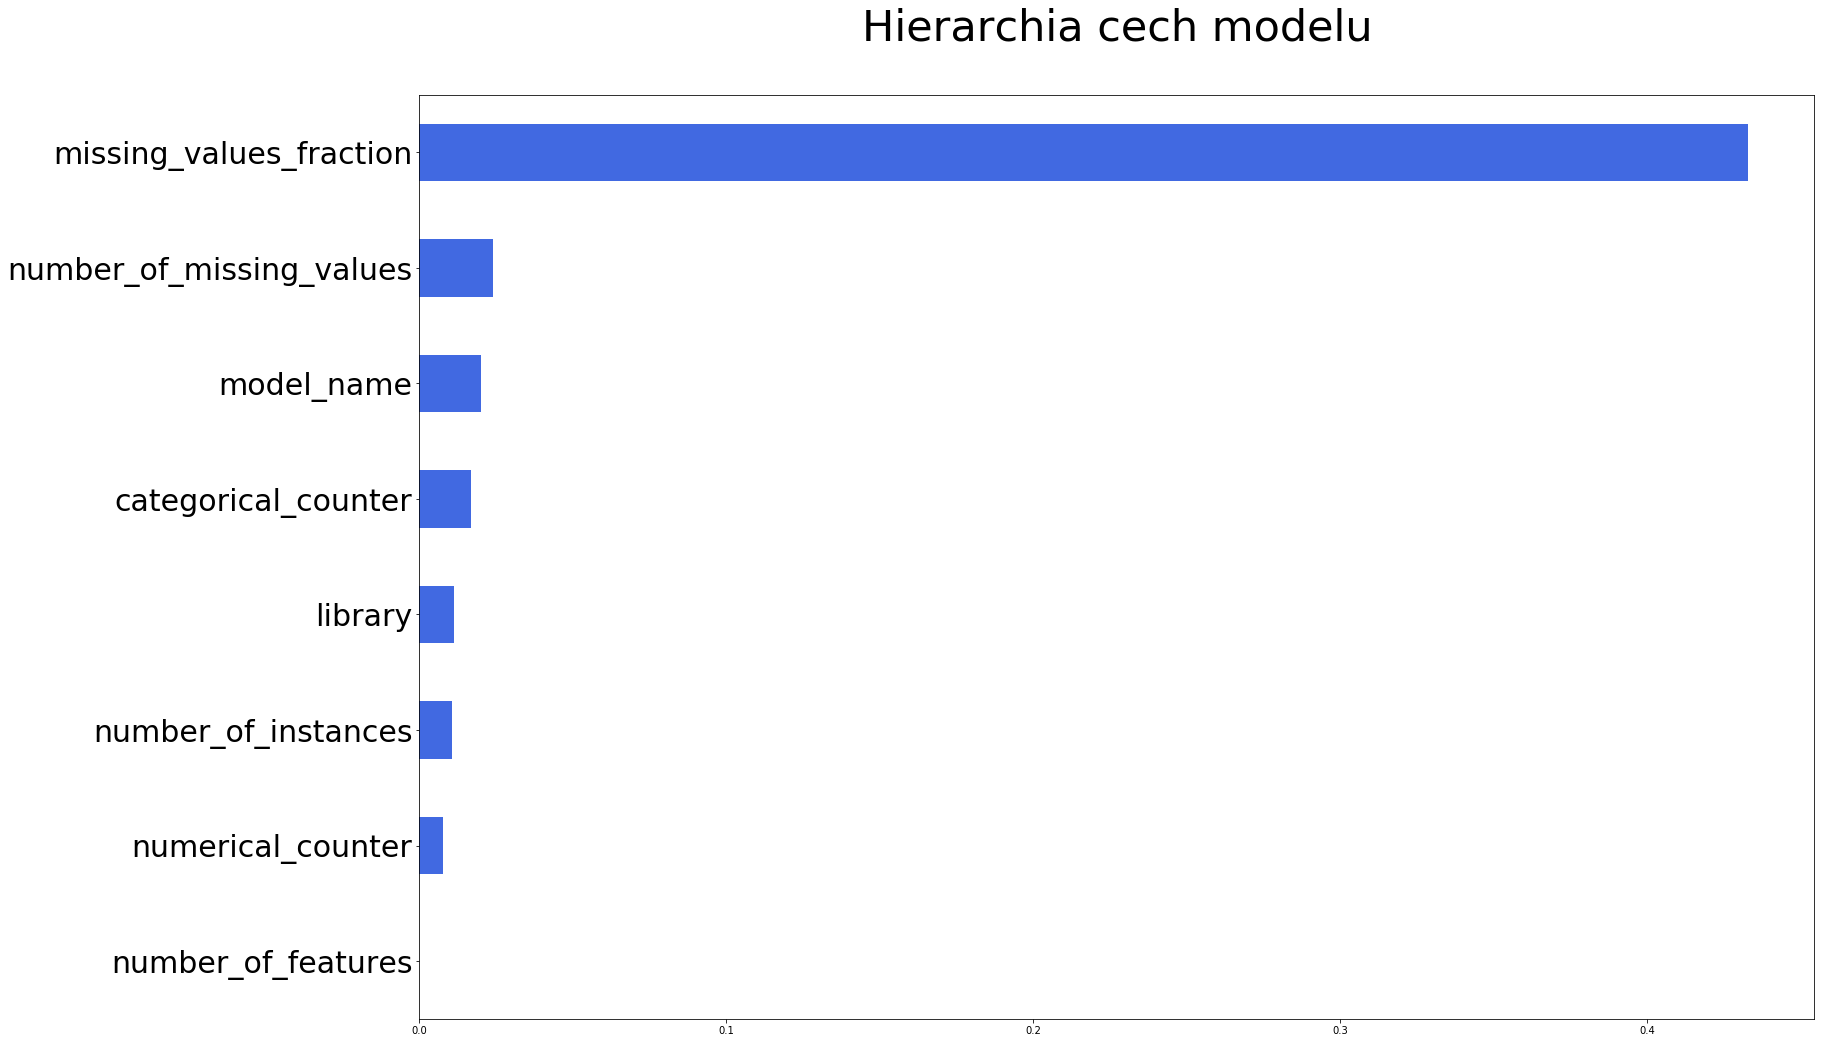

In [192]:
evaluate_model(X, y_acc, model_pipeline, True)